In [1]:
from keras.layers import *
from keras.models import Model, Sequential

generator = Sequential([
    Dense(128*7*7, input_dim=100),
    LeakyReLU(0.2),
    BatchNormalization(),
    Activation('relu'),
    Reshape((7,7,128)),
    Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'),
    LeakyReLU(0.2),
    BatchNormalization(),
    Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh')
])

discriminator = Sequential([
    Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'),
    LeakyReLU(0.2),
    Dropout(0.3),
    Conv2D(128, kernel_size=5, strides=2, padding='same'),
    # BatchNormalization(),
    LeakyReLU(0.2),
    Dropout(0.3),
    Flatten(),
    Dense(1),
    #BatchNormalization(),
    Activation('sigmoid'),
])

Using TensorFlow backend.


In [1]:
from gan_models.model_layers import UniformNoiseGenerator, get_dcgan_discriminator, get_dcgan_generator, ConvParams

MNIST_SHAPE = (28, 28, 1)
RANDOM_INPUT_SIZE = 100

generator = get_dcgan_generator(
    input_dim=RANDOM_INPUT_SIZE,
    shape_layer1=(7, 7, 128),
    conv_params_list=[
        ConvParams(filters=64, kernel_sizes=5, strides=2),
        ConvParams(filters=MNIST_SHAPE[-1], kernel_sizes=5, strides=2),
    ],
)
discriminator = get_dcgan_discriminator(
    input_shape=MNIST_SHAPE,
    conv_params_list=[
        ConvParams(filters=64, kernel_sizes=3, strides=2),
        ConvParams(filters=64, kernel_sizes=3, strides=2),
        ConvParams(filters=32, kernel_sizes=3, strides=1),
    ],
)

Using TensorFlow backend.


In [2]:
from gan_models.gan_trainer import GanTrainer
from gan_models.gan_loss import gan_discriminator_loss, gan_generator_loss
import keras

model_train = GanTrainer(generator, discriminator)
model_train.gan_compile(keras.optimizers.RMSprop(lr=0.0002, rho=0.5), gan_generator_loss, gan_discriminator_loss)

In [4]:
from gan_models.model_layers import UniformNoiseGenerator, get_dcgan_discriminator, get_dcgan_generator, ConvParams
from gan_models.model_layers import gan_generator_loss, gan_discriminator_loss 

import keras
from keras.models import Sequential


MNIST_SHAPE = (28, 28, 1)
RANDOM_INPUT_SIZE = 100

input_tensor =  keras.Input(shape=MNIST_SHAPE)
random_generator = UniformNoiseGenerator(-1, 1, RANDOM_INPUT_SIZE, input_shape=MNIST_SHAPE)


model_train_d_on_g = Sequential(name='d_on_g')
model_train_d_on_g.add(random_generator)
wrapped_generator = Sequential(layers=[generator])
wrapped_generator.trainable = False
model_train_d_on_g.add(wrapped_generator)
wrapped_discriminator = Sequential(layers=[discriminator])
wrapped_discriminator.trainable = True
model_train_d_on_g.add(wrapped_discriminator)


model_train_g_on_d = Sequential(name='g_on_d')
model_train_g_on_d.add(random_generator)
wrapped_generator = Sequential(layers=[generator])
wrapped_generator.trainable = True
model_train_g_on_d.add(wrapped_generator)
wrapped_discriminator = Sequential(layers=[discriminator])
wrapped_discriminator.trainable = False
model_train_g_on_d.add(wrapped_discriminator)

true_image_softmax = discriminator(input_tensor)
d_on_g_softmax = model_train_d_on_g(input_tensor)
g_on_d_softmax = model_train_g_on_d(input_tensor)

d_concat = keras.layers.concatenate([true_image_softmax, d_on_g_softmax])

train_discriminator = keras.models.Model(inputs=input_tensor, outputs=d_concat)
train_discriminator.compile(optimizer=keras.optimizers.Adam(), loss=gan_discriminator_loss)

train_generator = keras.models.Model(inputs=input_tensor, outputs=g_on_d_softmax)
train_generator.compile(optimizer=keras.optimizers.Adam(), loss=gan_generator_loss)

ValueError: A layer added to a Sequential model must not already be connected somewhere else. Model received layer sequential_1 which has 2 pre-existing inbound connections.

In [3]:
import numpy as np
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_train_scaled = (x_train - 127.5) / 127.5
x_train_scaled = x_train_scaled[:, :, :, None]

In [5]:
model_train.gan_fit(x_train_scaled, epochs=10, batch_size=128)

Epoch 1/10
60000/60000 [==============================] - 11s - loss: 0.9611 - sequential_3_loss_1: 1.2057 - sequential_3_loss_2: nan    
Epoch 2/10
60000/60000 [==============================] - 11s - loss: 0.8830 - sequential_3_loss_1: 1.2791 - sequential_3_loss_2: nan    
Epoch 3/10
 7040/60000 [==>...........................] - ETA: 9s - loss: 0.8225 - sequential_3_loss_1: 1.3729 - sequential_3_loss_2: nan - ETA: 11s - loss: 0.8169 - sequential_3_loss_1: 1.3919 - sequenti

KeyboardInterrupt: 

In [12]:
epoch = 30
batch_size = 128
import numpy


n_samples = x_train_scaled.shape[0]
n_batches = n_samples // batch_size
dummy_label = np.empty(batch_size)
for i in range(epoch):
    shuffled_idx = np.arange(n_samples)
    np.random.shuffle(shuffled_idx)
    losses = []
    for j in range(n_batches):
        batch_input = x_train_scaled[shuffled_idx[(j*batch_size):((j+1)*batch_size)]]
        losses.append(numpy.mean(model_train.train_on_batch(batch_input, [dummy_label, dummy_label])))
    print(numpy.mean(losses))


0.972608
0.880726
0.868003
0.862874
0.859092
0.850059
0.837732
0.809474
0.800714
0.79745
0.795486
0.785826
0.773533
0.762505
0.760862
0.749259
0.741938
0.726278
0.721436
0.709855
0.700945
0.698646
0.696097
0.688794
0.68453
0.685524
0.683285
0.68721
0.679279
0.673628


In [6]:
import time
epoch = 1
batch_size = 128


n_samples = x_train_scaled.shape[0]
n_batches = n_samples // batch_size
dummy_label = np.empty(batch_size)
for i in range(epoch):
    shuffled_idx = np.arange(n_samples)
    np.random.shuffle(shuffled_idx)
    d_losses = []
    g_losses = []
    for j in range(n_batches):
        batch_input = x_train_scaled[shuffled_idx[(j*batch_size):((j+1)*batch_size)]]
        d_losses.append(model_train.discriminator_train_on_batch(batch_input))
        g_losses.append(model_train.generator_train_on_batch(batch_input))
    print('Epoch {}'.format(i+1))

Epoch 1


In [7]:
d_losses
    

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [9]:
batch_input.shape

(128, 28, 28, 1)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_output():
    try_input = np.random.rand(100, 100)
    preds = generator.predict(try_input)

    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()

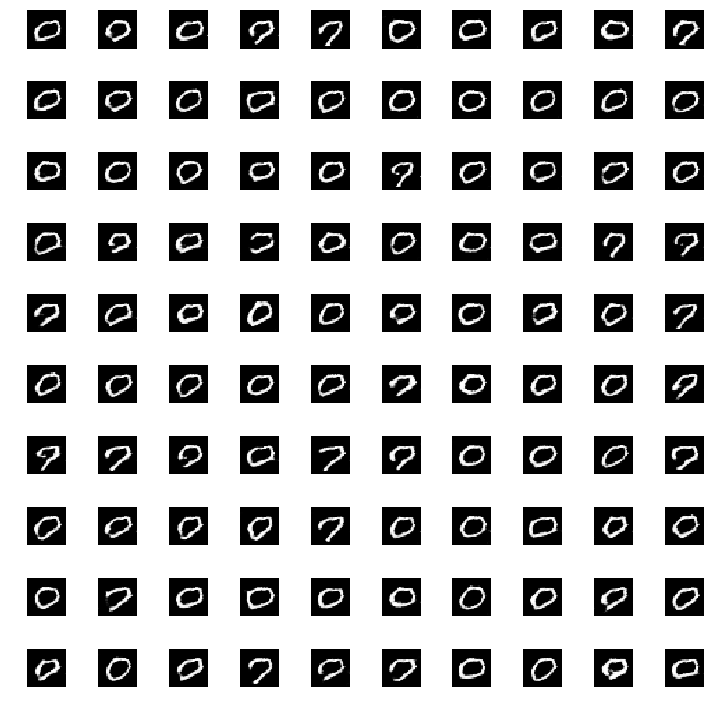

In [11]:
plot_output()

In [6]:
import keras.backend as K
K.zeros((100,))

<tf.Variable 'Variable_1:0' shape=(100,) dtype=float32_ref>

In [9]:
model_train_g_on_d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
uniform_noise_generator_1 (U (None, 100)               0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_8 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [9]:
discriminator.predict(x_train_scaled[:10,:,:,None])

array([[ 0.99861038],
       [ 0.99867475],
       [ 0.99527538],
       [ 0.99743623],
       [ 0.99871004],
       [ 0.9993062 ],
       [ 0.99839884],
       [ 0.99904686],
       [ 0.99805659],
       [ 0.99822098]], dtype=float32)

In [ ]:
model_train_g_on_d.get_config()

In [ ]:
[model_train_g_on_d.layers[0].trainable,
model_train_g_on_d.layers[1].trainable]

In [ ]:
[model_train_d_on_g.layers[0].trainable,
model_train_d_on_g.layers[1].trainable]

In [ ]:
generator.trainable = True